In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd
import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
from time import time

import FrEIA.framework  as Ff
import FrEIA.modules as Fm

import losses
import monitoring
import utils

In [46]:
'''Global configuration for the experiments'''

######################
#  General settings  #
######################

# Filename to save the model under
filename_out    = 'output/cond_inn.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 1e-2
#Batch size
batch_size      = 128
# Total number of epochs to train for
n_epochs        = 50

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 3
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x_class     = 3
ndim_pad_x_class = 17
ndim_x_features     = 7
ndim_pad_x_features = 505

ndim_y     = 512
ndim_z     = 20
ndim_pad_zy = 0

assert (ndim_x_class + ndim_x_features + ndim_pad_x_class+ ndim_pad_x_features 
        == ndim_y + ndim_z + ndim_pad_zy), "Dimensions don't match up"

############
#  Losses  #
############

train_forward_mmd    = True
train_backward_mmd   = True
train_reconstruction = False
train_max_likelihood = False

lambd_fit_forw         = 0.1
lambd_mmd_forw         = 500.
lambd_reconstruct      = 1.
lambd_mmd_back_class   = 1000.
lambd_mmd_back_feature = 500.
lambd_max_likelihood   = 1.


# Both for fitting, and for the reconstruction, perturb y with Gaussian 
# noise of this sigma
add_y_noise     = 5e-2 # think of smth smart here
# For reconstruction, perturb z 
add_z_noise     = 2e-2
# In all cases, perturb the zero padding
add_pad_noise   = 1e-2

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4

mmd_forw_kernels = [(0.2, 2), (1.5, 2), (3.0, 2)]
mmd_back_kernels = [(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 5
#
exponent_clamping = 1.0
#
hidden_layer_sizes = 64
#
use_permutation = True
#
verbose_construction = False

In [47]:
inputs,labels = utils.read_data('/home/slaskina/simulations', ndim_x_class, ndim_x_features, ndim_y, conditioned = True)

In [48]:
(train_indices, val_indices, test_indices), train_loader, test_loader = utils.create_loaders(inputs, labels, batch_size)

### from here are the model and train modeules are defined to avoid restarting 

In [49]:
def subnet2(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  dims_out))


def subnet1(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, hidden_layer_sizes*2), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes*2,  hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  dims_out))

input1 = Ff.InputNode(ndim_x_class + ndim_pad_x_class, name='input_class')
input2 = Ff.InputNode(ndim_x_features + ndim_pad_x_features, name='input_features')

shape_condition = Ff.ConditionNode(ndim_x_class, name='input_class')
nodes = [input1]
nodes.append(shape_condition)
nodes.append(Ff.Node(nodes[-2].out0, Fm.RNVPCouplingBlock, {'subnet_constructor':subnet2, 'clamp':exponent_clamping},conditions = nodes[-1], name = 'coupling_conditioned'))

for i in range(N_blocks//2):
    nodes.append(Ff.Node(nodes[-1].out0, Fm.RNVPCouplingBlock, {'subnet_constructor':subnet1, 'clamp':exponent_clamping}, name = 'coupling_{}'.format(i)))

nodes.append(input2)
nodes.append( Ff.Node([nodes[-2].out0, nodes[-1].out0], Fm.Concat, {}, name='Concat'))
for i in range(N_blocks):
    nodes.append(Ff.Node(nodes[-1].out0, Fm.RNVPCouplingBlock, {'subnet_constructor':subnet2, 'clamp':exponent_clamping}, name = 'coupling_{}'.format(i)))
    if use_permutation:
        nodes.append(Ff.Node([nodes[-1].out0], Fm.PermuteRandom, {'seed':i}, name='permute_{}'.format(i)))

nodes.append(Ff.OutputNode([nodes[-1].out0], name='output'))
model = Ff.GraphINN(nodes, verbose=verbose_construction)
      
model.to(device)

params_trainable = list(filter(lambda p: p.requires_grad, model.parameters()))
for p in params_trainable:
    p.data = init_scale * torch.randn(p.data.shape).to(device)

gamma = (final_decay)**(1./n_epochs)
optim = torch.optim.Adam(params_trainable, lr=lr_init, betas=adam_betas, eps=1e-6, weight_decay=l2_weight_reg)
weight_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=gamma)

def optim_step():
    #for p in params_trainable:
        #print(torch.mean(torch.abs(p.grad.data)).item())
    optim.step()
    optim.zero_grad()

def scheduler_step():
    #weight_scheduler.step()
    pass

def save(name):
    torch.save({'opt':optim.state_dict(),
                'net':model.state_dict()}, name)

def load(name):
    state_dicts = torch.load(name)
    model.load_state_dict(state_dicts['net'])
    try:
        optim.load_state_dict(state_dicts['opt'])
    except ValueError:
        print('Cannot load optimizer for some reason or other')


In [50]:

def noise_batch(ndim):
    return torch.randn(batch_size, ndim).to(device)

def loss_max_likelihood(out, y):
    jac = model.jacobian(run_forward=False)

    neg_log_likeli = ( 0.5 / y_uncertainty_sigma**2 * torch.sum((out[:, -ndim_y:]       - y[:, -ndim_y:])**2, 1)
                     + 0.5 / zeros_noise_scale**2   * torch.sum((out[:, ndim_z:-ndim_y] - y[:, ndim_z:-ndim_y])**2, 1)
                     + 0.5 * torch.sum(out[:, :ndim_z]**2, 1)
                     - jac)

    return lambd_max_likelihood * torch.mean(neg_log_likeli)

def loss_forward_mmd(out, y):
    # Shorten output, and remove gradients wrt y, for latent loss
    # [z,y] only
    output_block_grad = torch.cat((out[:, :ndim_z],
                                   out[:, -ndim_y:].data), dim=1) 
    y_short = torch.cat((y[:, :ndim_z], y[:, -ndim_y:]), dim=1)

    l_forw_fit = lambd_fit_forw * losses.l2_fit(out[:, ndim_z:], y[:, ndim_z:])
    l_forw_mmd = lambd_mmd_forw  * torch.mean(losses.forward_mmd(output_block_grad, y_short))

    return l_forw_fit, l_forw_mmd

def loss_backward_mmd(x_class, x_features, y, x_cond):
    [x_samples_class, x_samples_features], x_samples_jac = model(y, rev=True, jac = False,c= x_cond) 
    MMD_class = losses.backward_mmd(x_class, x_samples_class) 
    MMD_features = losses.backward_mmd(x_features, x_samples_features)
    if mmd_back_weighted:
        MMD_class *= torch.exp(- 0.5 / y_uncertainty_sigma**2 * losses.l2_dist_matrix(y, y))
        MMD_features *= torch.exp(- 0.5 / y_uncertainty_sigma**2 * losses.l2_dist_matrix(y, y))
    return lambd_mmd_back_class * torch.mean(MMD_class)+lambd_mmd_back_feature * torch.mean(MMD_features)


def loss_reconstruction(out_y, x, x_cond):
    cat_inputs = [out_y[:, :ndim_z] + add_z_noise * noise_batch(ndim_z)] # list with 1 tensor
    
    if ndim_pad_zy:
        cat_inputs.append(out_y[:, ndim_z:-ndim_y] + add_pad_noise * noise_batch(ndim_pad_zy)) # list with 2 tensor
    cat_inputs.append(out_y[:, -ndim_y:] + add_y_noise * noise_batch(ndim_y)) # list with 3 tensors
    x_reconstructed_class, x_reconstructed_features, x_reconstructed_jac = model(torch.cat(cat_inputs, 1), rev=True,c= x_cond) # concatenate list elements along axis 1
    return lambd_reconstruct * losses.l2_fit(x_reconstructed, x) # needs fix

def train_epoch(i_epoch, test=False):
    if not test:
        model.train()
        loader = train_loader

    if test:
        model.eval()
        loader = test_loader
        nograd = torch.no_grad()
        nograd.__enter__()


    batch_idx = 0
    loss_history = []

    for x, y in loader:

        if batch_idx > n_its_per_epoch:
            break
        batch_losses = []

        batch_idx += 1

        #x, y = Variable(x).to(device), Variable(y).to(device)
        x, y = x.to(device), y.to(device)

        if add_y_noise > 0:
            y += add_y_noise * noise_batch(ndim_y)
        x_cond = x[:,-3:]
        if ndim_pad_x_class:
            # x = [x, pad_x]
            x_class = torch.cat((x[:,:3], add_pad_noise * noise_batch(ndim_pad_x_class)), dim=1)
        
        if ndim_pad_x_features:
            # x = [x, pad_x]
            x_features = torch.cat((x[:,3:-3], add_pad_noise * noise_batch(ndim_pad_x_features)), dim=1)
        if ndim_pad_zy:
            y = torch.cat((add_pad_noise * noise_batch(ndim_pad_zy), y), dim=1)
        # y = [z, pad_yz, y]
        y = torch.cat((noise_batch(ndim_z), y), dim=1)

        out_y, out_y_jac = model([x_class,x_features], jac  = False, c= x_cond)
        # tuple with output[0] and jacobian[1]
        if train_max_likelihood:
            batch_losses.append(loss_max_likelihood(out_y, y))

        if train_forward_mmd:
            batch_losses.extend(loss_forward_mmd(out_y, y))

        if train_backward_mmd:
            batch_losses.append(loss_backward_mmd(x_class,x_features, y, x_cond))

        if train_reconstruction:
            batch_losses.append(loss_reconstruction(out_y.data, x, x_cond))

        l_total = sum(batch_losses)
        loss_history.append([l.item() for l in batch_losses]) # lisr of lists: list for each batch

        if not test:
            l_total.backward()
            optim_step()

    if test:
        monitoring.show_hist(out_y[:, :ndim_z])
        monitoring.show_cov(out_y[:, :ndim_z])
        if test_time_functions:
            out_x_class, out_x_features, out_x_jac = model(y, rev=True, jac = False,c= x_cond) 
            for f in test_time_functions:
                f(out_x_class, out_x_features, out_y, x_class,x_features, y)

        nograd.__exit__(None, None, None)
    return np.mean(loss_history, axis=0)

def train():
    monitoring.restart()

    try:
        monitoring.print_config()
        t_start = time()
        for i_epoch in range(-pre_low_lr, n_epochs):

            if i_epoch < 0:
                for param_group in optim.param_groups:
                    param_group['lr'] = lr_init * 1e-1

            train_losses = train_epoch(i_epoch) # mean over batches
            test_losses  = train_epoch(i_epoch, test=True)
            t = np.concatenate([train_losses, test_losses])
            monitoring.show_loss(t)
            scheduler_step() 

    except:
        save(filename_out + '_ABORT')
        raise

    finally:
        print("\n\nTraining took %f minutes\n\n" % ((time()-t_start)/60.))
        save(filename_out)


In [51]:
train()

Config options:

  N_blocks                 	5
  adam_betas               	(0.9, 0.95)
  add_pad_noise            	0.01
  add_y_noise              	0.05
  add_z_noise              	0.02
  batch_size               	256
  device                   	cuda
  exponent_clamping        	3.0
  filename_in              	
  filename_out             	output/my_inn.pt
  final_decay              	0.02
  hidden_layer_sizes       	16
  init_scale               	0.1
  interactive_visualization	False
  l2_weight_reg            	1e-05
  lambd_fit_forw           	10.0
  lambd_max_likelihood     	1.0
  lambd_mmd_back_class     	500.0
  lambd_mmd_back_feature   	50.0
  lambd_mmd_forw           	50.0
  lambd_reconstruct        	1.0
  lr_init                  	0.001
  mmd_back_kernels         	[(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
  mmd_back_weighted        	True
  mmd_forw_kernels         	[(0.2, 2), (1.5, 2), (3.0, 2)]
  n_epochs                 	25
  n_its_per_epoch          	200
  ndim_pad_x_class         	39

In [52]:
from visualizations import plot_outcomes_identified, describe_false_shapes, describe_positive_shapes, create_table_from_outcome

In [53]:
def make_prediction(labels, model, cond):
    y = torch.cat((add_pad_noise * torch.randn( len(labels), ndim_pad_zy).to('cuda'), labels.to('cuda')), dim=1)
    y = torch.cat((torch.randn( len(labels), ndim_z).to('cuda'), y), dim=1)
    [pred_class, pred_features], _ = model(y, rev = True, c=cond.to('cuda'))  # output of NN without padding
    return np.concatenate((pred_class.cpu().detach()[:,:ndim_x_class], pred_features.cpu().detach()[:, :ndim_x_features]), axis=1)


In [54]:
df_train = create_table_from_outcome(utils.make_prediction(labels[train_indices], model, ndim_x_class, ndim_x_features, ndim_z, ndim_pad_zy,add_pad_noise, inputs[train_indices,-3:]), inputs[train_indices,:-3])
df_val = create_table_from_outcome(utils.make_prediction(labels[val_indices],model, ndim_x_class, ndim_x_features, ndim_z, ndim_pad_zy,add_pad_noise, inputs[val_indices,-3:]), inputs[val_indices,:-3]) 
df_test = create_table_from_outcome(utils.make_prediction(labels[test_indices], model, ndim_x_class, ndim_x_features, ndim_z, ndim_pad_zy,add_pad_noise, inputs[test_indices,-3:]), inputs[test_indices,:-3])

Accuracy is 84.03%
MSE for radius per shape for correctly identified instances as follows: sphere: 154.5806, hardsphere: 132.5302 and cylinder: 19336.5332
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 61732.6367, hardsphere: 477.3010 and cylinder: 482234.7812
MSE for cylinder length for correctly identified instances: 36298.3086
MSE for cylinder length polydispersity for correctly identified instances: 57.2129
MSE for cylinder length for correctly identified instances: 5.7770


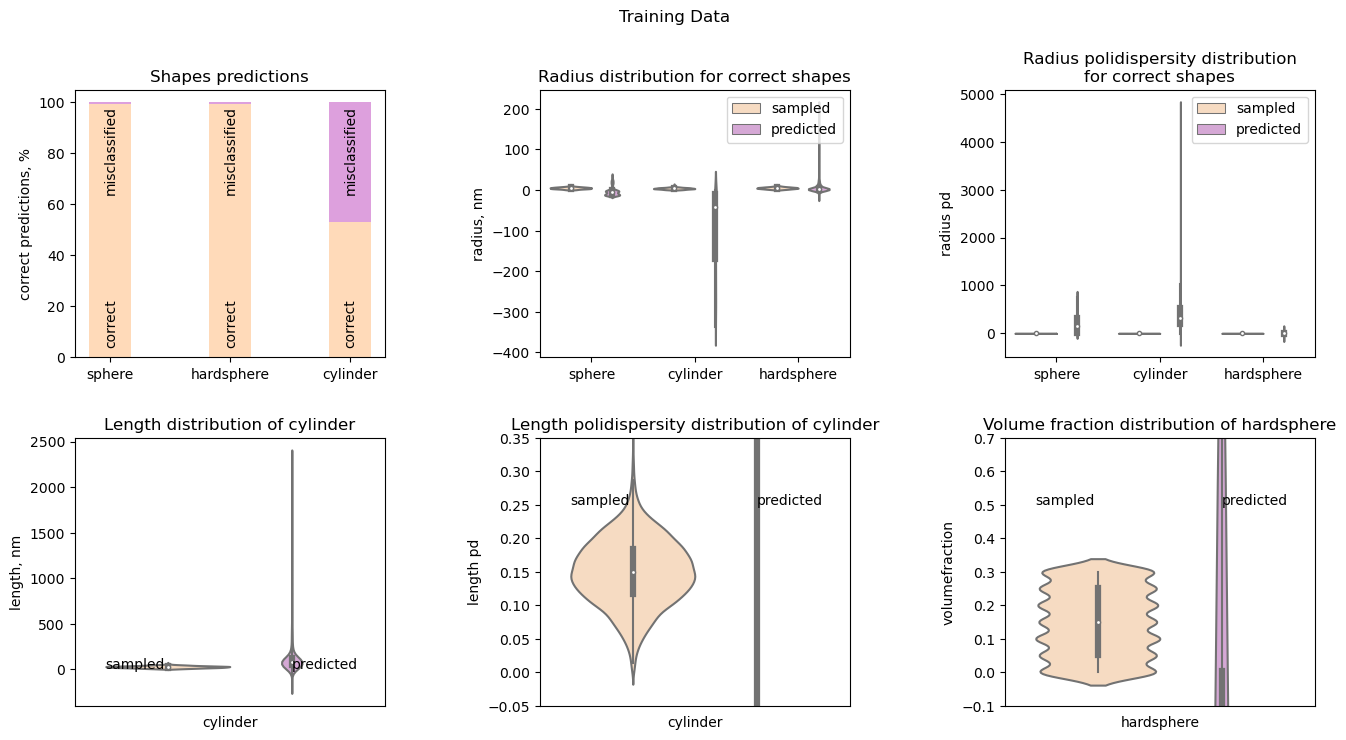

In [55]:
plot_outcomes_identified(df_train, 'Training')

Accuracy is 83.37%
MSE for radius per shape for correctly identified instances as follows: sphere: 153.5257, hardsphere: 129.5138 and cylinder: 19230.6719
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 63906.1875, hardsphere: 424.6394 and cylinder: 435759.6250
MSE for cylinder length for correctly identified instances: 28432.0918
MSE for cylinder length polydispersity for correctly identified instances: 52.7188
MSE for cylinder length for correctly identified instances: 5.3074


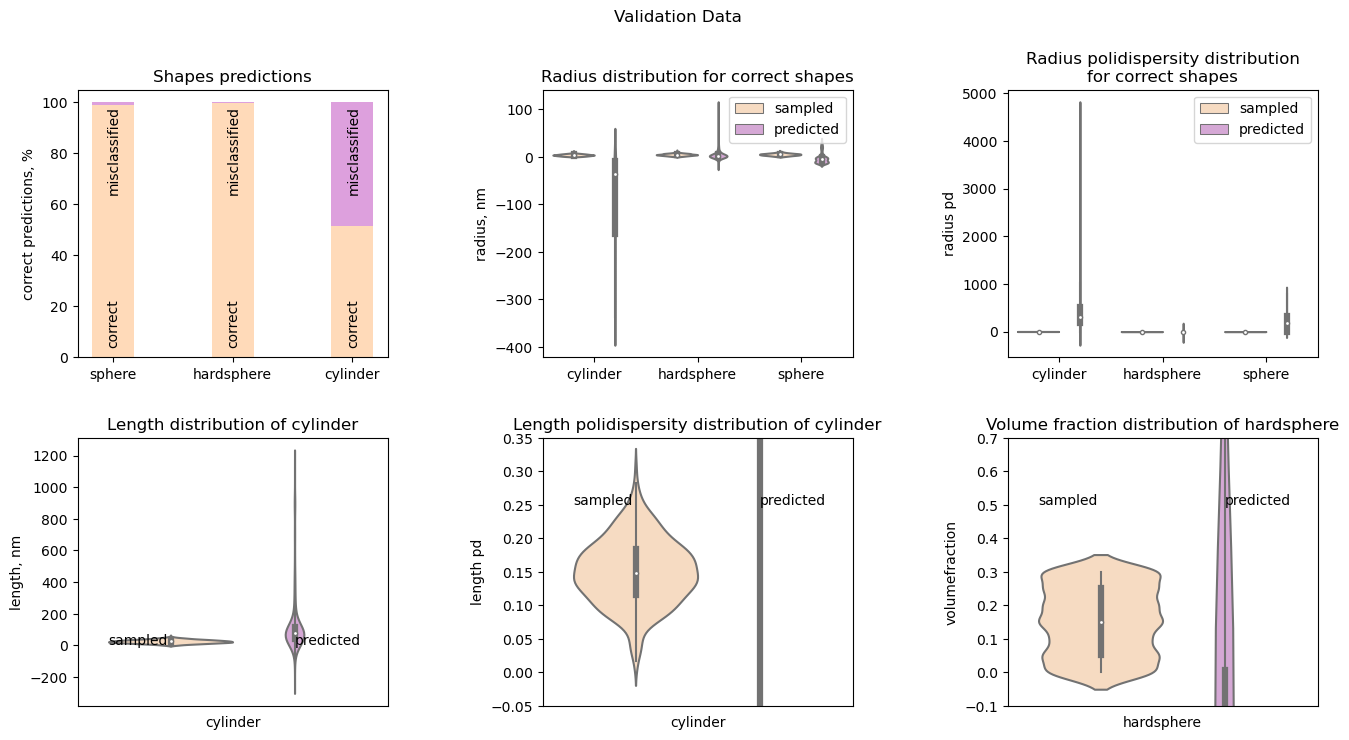

In [56]:
plot_outcomes_identified(df_val, 'Validation')

Accuracy is 82.20%
MSE for radius per shape for correctly identified instances as follows: sphere: 149.6342, hardsphere: 129.4804 and cylinder: 16780.4434
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 58359.2344, hardsphere: 547.0791 and cylinder: 404323.5312
MSE for cylinder length for correctly identified instances: 22088.3457
MSE for cylinder length polydispersity for correctly identified instances: 40.4383
MSE for cylinder length for correctly identified instances: 5.6115


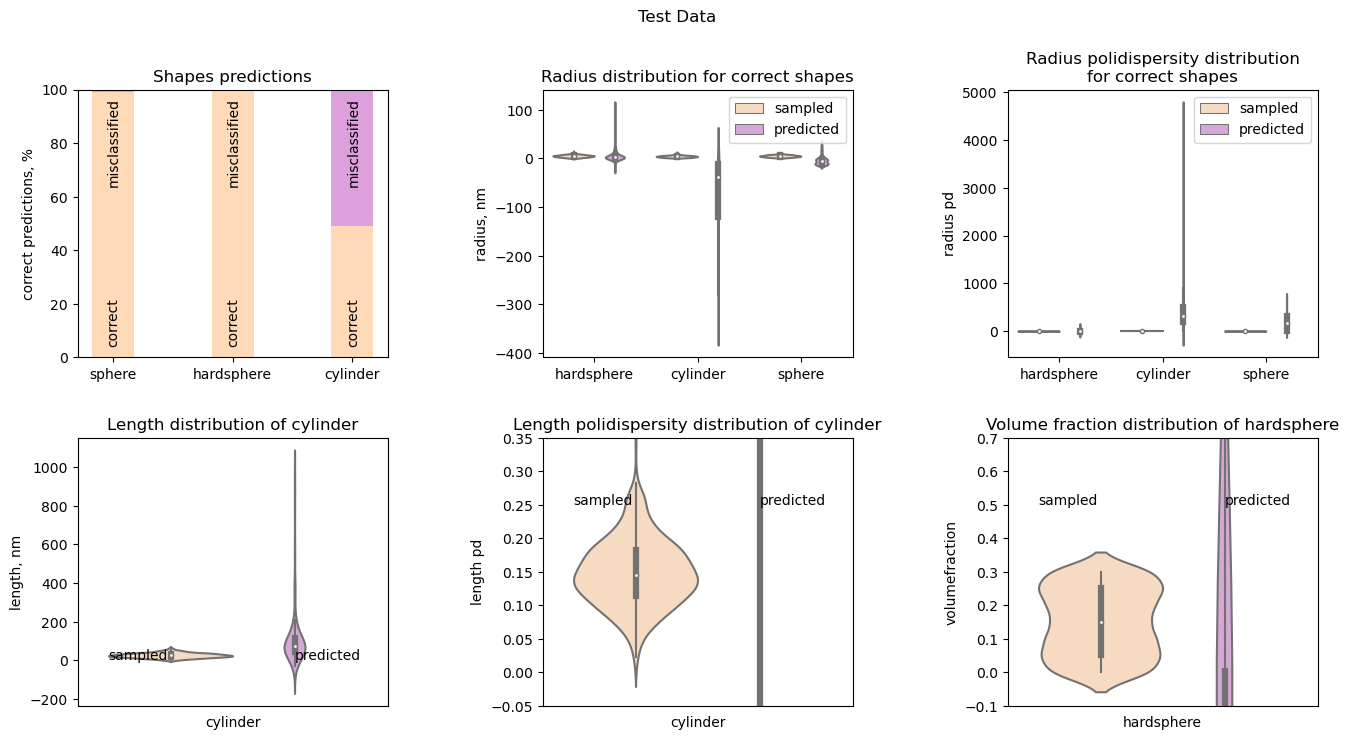

In [57]:
plot_outcomes_identified(df_test, 'Test')

In [45]:
df_test

,true_shape,pred_shape,radius,pred_radius,radius_pd,pred_radius_pd,length,pred_length,length_pd,pred_length_pd,volfraction,pred_volfraction
0,1,1,4.521623,-44.692188,0.137957,-78.843704,0.000000,-0.868851,0.000000,-19.995090,0.20,1.977351
1,2,2,7.016451,-711.316223,0.110119,-2500.756104,15.069812,31.654743,0.166154,-7098.062988,0.00,25.140455
2,2,2,6.242439,-870.608521,0.104703,-2536.483398,23.140541,4.770230,0.257852,-10038.640625,0.00,49.515118
3,2,2,8.598413,-723.907471,0.146229,-2452.276367,10.450610,37.196743,0.118462,-7611.540527,0.00,23.113783
4,1,1,5.372845,-9.124294,0.139639,-20.259150,0.000000,-0.594597,0.000000,-29.220366,0.05,1.628616
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1,1,0.215263,4.323771,0.103530,0.085732,0.000000,0.201389,0.000000,-0.029588,0.30,0.005717
1496,0,2,7.928937,-615.671265,0.070772,-1851.557007,0.000000,-7.955384,0.000000,-5692.890137,0.00,22.572958
1497,2,2,2.721311,-292.474365,0.158766,-482.179932,34.106861,-17.111185,0.126336,-2449.028564,0.00,12.519482
1498,0,0,6.885484,12.267082,0.064197,-981.821106,0.000000,-29.104925,0.000000,-3381.206055,0.00,18.795403


In [ ]:
false_shapes = df_test[df_test.true_shape != df_test.pred_shape]

FN_spheres = false_shapes[false_shapes.true_shape == 0]
FP_spheres = false_shapes[false_shapes.pred_shape == 0]
false_spheres = pd.concat([FN_spheres, FP_spheres])

FN_hardspheres = false_shapes[false_shapes.true_shape == 1]
FP_hardspheres = false_shapes[false_shapes.pred_shape == 1]
false_hardspheres = pd.concat([FN_hardspheres, FP_hardspheres])

FN_cylinders = false_shapes[false_shapes.true_shape == 2]
FP_cylinders = false_shapes[false_shapes.pred_shape == 2]
false_cylinders = pd.concat([FN_cylinders, FP_cylinders])

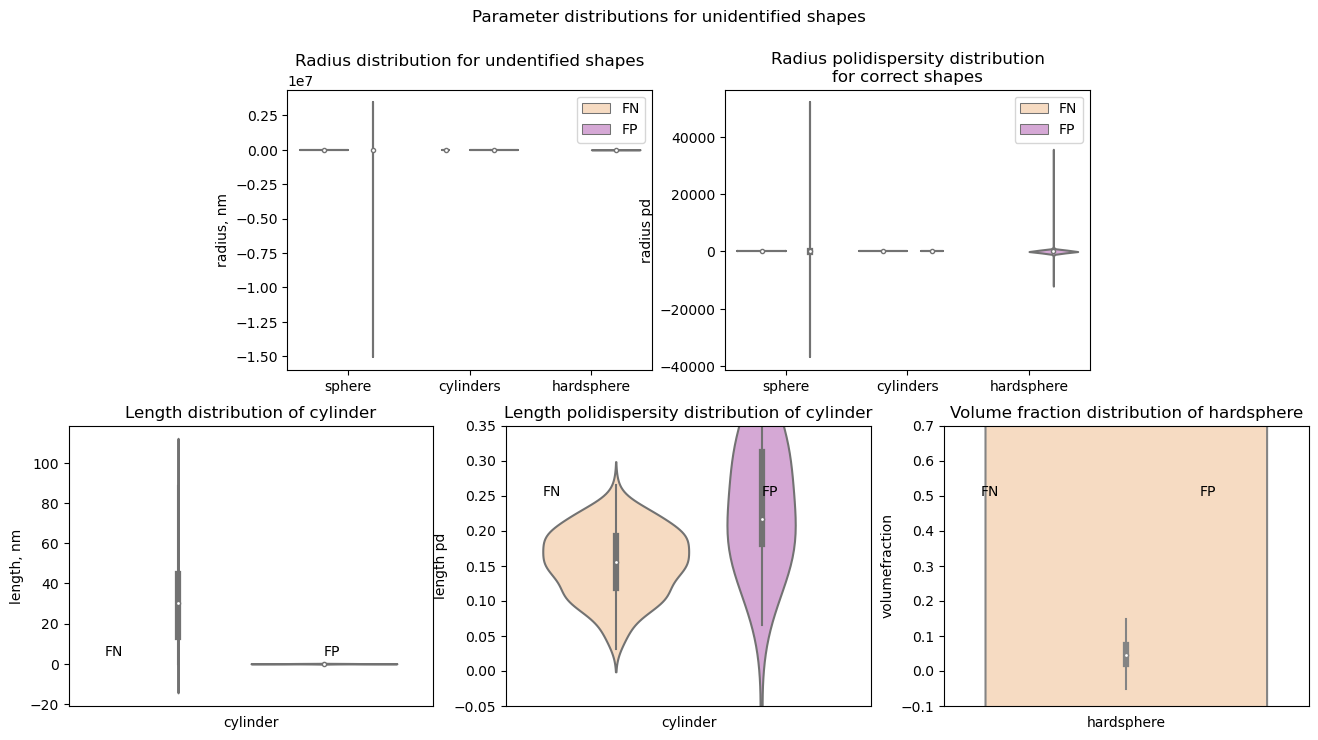

In [ ]:
describe_false_shapes(false_spheres, false_hardspheres, false_cylinders)

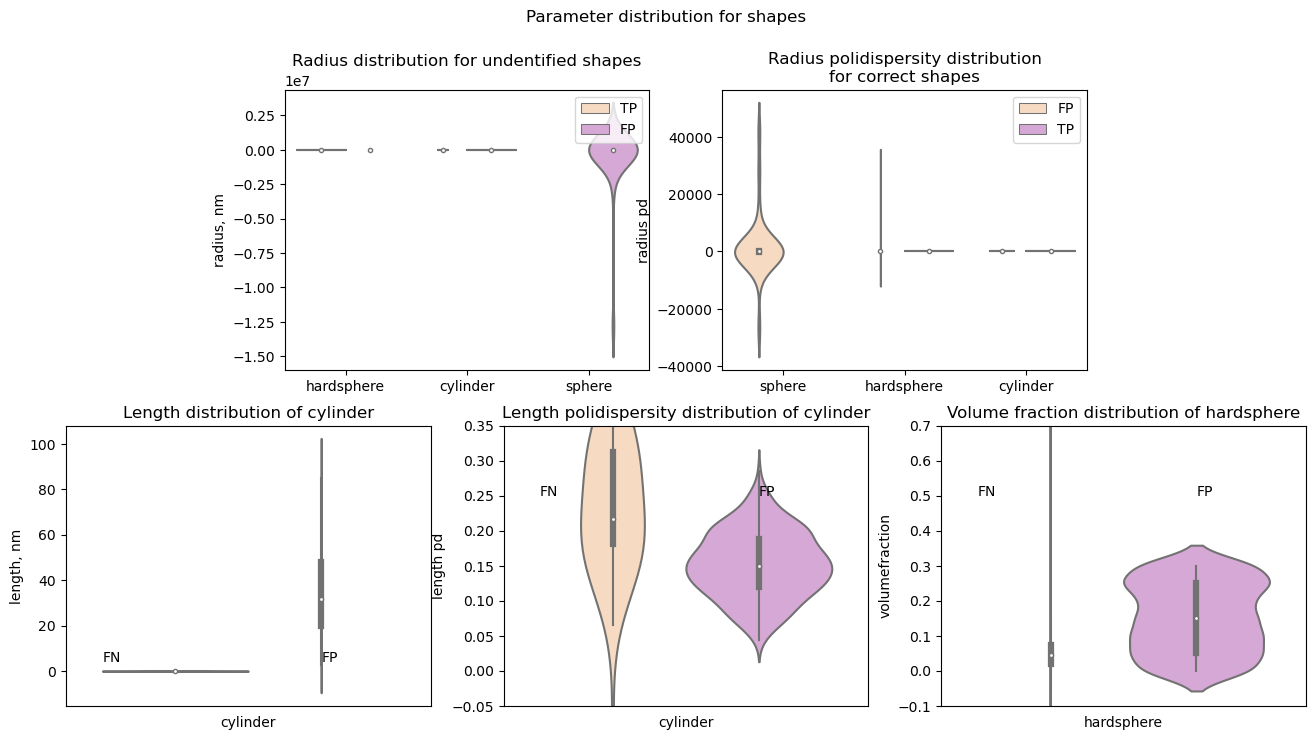

In [ ]:
describe_positive_shapes(df_test)